In [1]:
using Pkg
pkg"activate ."
pkg"instantiate"
pkg"precompile"

  Updating registry at `C:\Users\Chiyoung Ahn\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [2]:
using PerlaTonettiWaugh, Plots, BenchmarkTools, CSV

┌ Info: Recompiling stale cache file C:\Users\Chiyoung Ahn\.julia\compiled\v1.1\PerlaTonettiWaugh\Zi3ee.ji for PerlaTonettiWaugh [d2cacc76-b06b-11e8-362b-f18d03a16405]
└ @ Base loading.jl:1184


In [3]:
gr(fmt = :png)

Plots.GRBackend()

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

Below are the results from the **updated** matlab calibration with the corresponding letters. Here I added the $\mu$ parameter in the calibration routine to fit the firm dynamic moments. Fit improved a lot and it generated a negative drift term which is what we need to keep S from going negative.


In [4]:
parameters = (ρ = 0.02, σ = 3.05, N = 10, θ = 4.9411, γ = 1.0, κ = 0.1317, ζ = 1.0, η = 0.0, Theta = 1, χ = 0.18880392712168415, υ = 0.0553, μ = -0.0115, δ = 0.05, d = 2.9753)

(ρ = 0.02, σ = 3.05, N = 10, θ = 4.9411, γ = 1.0, κ = 0.1317, ζ = 1.0, η = 0.0, Theta = 1, χ = 0.18880392712168415, υ = 0.0553, μ = -0.0115, δ = 0.05, d = 2.9753)

In [5]:
#5.0672    3.2941    0.1152    4.7847   -0.0289    0.0819    2.3664

parameters = merge(parameters, (ρ = 0.0195, d = 5.0672, θ = 3.2941,  κ = 0.1152, χ = 1/4.7847, υ = 0.0819, μ = -0.0289, σ = 2.3664,))

(ρ = 0.0195, σ = 2.3664, N = 10, θ = 3.2941, γ = 1.0, κ = 0.1152, ζ = 1.0, η = 0.0, Theta = 1, χ = 0.2089995193011056, υ = 0.0819, μ = -0.0289, δ = 0.05, d = 5.0672)

In [6]:
changed_parameters = false # set this to true if you drastically change the parameters

false

Side note on previous version. Essentially, under this calibration, the parameters are very simmilar. Theta, chi, kappa are quite close to what we had in the prior version.

In [7]:
# Define common objects. 
#parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))
settings = merge(settings, (z_ex = unique([range(0., 0.1, length = 400)' range(0.1, 1., length = 400)' range(1., 5, length = 100)']),
        z = unique([range(0., 0.1, length = 400)' range(0.1, 1., length = 400)' range(1., 5, length = 100)'])[2:end-1]))
P = length(settings.z) - 2

d_0 = parameters.d # Here is the 10 percent tariff increase
d_T = 1 + (parameters.d-1)*0.90

d_autarky = 1 + (parameters.d-1)*2.5 

params_0 = merge(parameters, (d = d_0, )) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T, )) # parameters to be used at t = T
params_autarky = merge(parameters, (d = d_autarky, )) # parameters to be used in autarky calc

# initial value for numerical solver on (g, z_hat, Omega)
initial_x = [0.02; 2; .57]

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_algebraic(params_0, initial_x) # solution at t = 0
stationary_sol = stationary_algebraic(params_T, initial_x) # solution at t = T
stationary_autarky = stationary_algebraic(params_autarky, initial_x) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

In [8]:
d_0

5.0672

In [9]:
print(stationary_sol.U_bar,'\n') 
print(stationary_sol_0.U_bar,'\n')
print(stationary_sol_0.S,'\n')
print(stationary_autarky.S,'\n')

31.96080639716944
25.33520562193782
0.08792930215911848
0.061111899850438134


In [10]:
#T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar, stationary_sol_0.U_bar, parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")
print("SS to SS welfare gain: ", stationary_sol.λ_ii,"\n")

SS to SS welfare gain: 13.791679181400717
SS to SS welfare gain: 0.8650014500550754


In [11]:
print("SS to SS welfare gain: ", stationary_sol.g,"\n")

SS to SS welfare gain: 0.011575084222623199


### This is the autarky calculation

In [12]:
#T = solved.t[end]
lambda_ss_autarky = 100*(consumption_equivalent(stationary_autarky.U_bar, stationary_sol_0.U_bar, parameters)-1)

print("SS to SS welfare gain: ", lambda_ss_autarky,"\n")
print("Autarky Home Share, should be close to 1: ", stationary_autarky.λ_ii,"\n")
print("Autarky TFP growth rate ", stationary_autarky.g,"\n")

SS to SS welfare gain: -31.541980650737255
Autarky Home Share, should be close to 1: 0.9916620326433107
Autarky TFP growth rate 0.0006996951761301074


## Welfare in Steady States

### Steady state at `T`

In [13]:
stationary_sol.U_bar

31.96080639716944

### Steady state at `0`

In [14]:
stationary_sol_0.U_bar

25.33520562193782

### Outstanding Issue \#1: Sensitivity of growth to trade.

This is a big difference relative to previous version. As noted above, with parameter values that are quite similar to what we had before, the growth rate is changing a lot with only a very small change in trade flows. Why?

In [15]:
@show stationary_sol.g, stationary_sol_0.g;

(stationary_sol.g, stationary_sol_0.g) = (0.011575084222623199, 0.00884073591826919)


---

# Transition dynamics

Setup for optimizer:

In [16]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_numerical(params_T, settings.z_ex), Ω_0 = Ω_0, T = 75.0));

Use the solution found with calibrated parameters above for `E`

In [17]:
settings = merge(settings, (transition_x0 = [-0.8738884967642274, -0.5125465450602664, -0.31163166531947395, -0.1789036699964298, -0.09444764803478085, -0.06676386406358947, -0.03212999344363521, -0.031163943690287882, -0.02126451604463498, -0.006571948963575373, -0.004883226411956144, -0.004613812088943909, -0.003969056948433287, -0.00037064145316761054, -0.0002608582052007029], 
        )); # remove tstops when solving the model for the first time to get a rough solution first

Find the corresponding solution

In [18]:
@time result = solve_full_model(merge(settings, (transition_iterations = (changed_parameters ? 1000 : 0),)); 
    impose_E_monotonicity_constraints = true, write_data = false, 
    run_global = false)

solved = result.solution;
E_nodes = result.E_nodes;
solved = solved.results;

309.076473 seconds (1.86 G allocations: 300.732 GiB, 12.33% gc time)


---
## Welfare Gains

In [19]:
print("Utility in initial SS: ", stationary_sol_0.U_bar,"\n")
print("Utility in new SS: ", stationary_sol.U_bar,"\n")

Utility in initial SS: 25.33520562193782
Utility in new SS: 31.96080639716944


In [20]:
print("Utility immediately after change ", solved.U[1],"\n")

Utility immediately after change 33.03775170948629


#### Summary so far...

In the old paper, what we did was take U_0_ss at some date t, then compare it to U_ss at the same date t. This is like an instantaneous jump to the new ss. This is what the first cell is looking at and note that this is like a 17 percent increase in utility. Higher than what we had in the paper, but in of the same order of magnitude. 

The next cell reprots the utility just after the change. Utility here includes the future path of consumption and change in growth rate, so it "bakes in" the transition path. Here it goes up by much more than utility in the new SS. This is what I was expecting given the dynamics of consumption. 

Just a reminder about how the function `counsumption_equivalent(U_new, U_old, parameters)` works, it takes U_new and then U_old in that order, then evaluates the **gross** increase in consumption. 100 times this value **minus one** gives the permanent, percent increase in consumption required to make the agent indifferent between the two paths. 

In [21]:
#T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar, stationary_sol_0.U_bar, parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")

SS to SS welfare gain: 13.791679181400717


In [22]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_sol_0.U_bar, parameters)-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

Inclusive of the Transition Path: 16.20662245894877


### Relative to initial notebook computations

- SS to SS, the issue here is that we should compare **at date 0** utility in the first ss vs. the second ss. This is what we must have been doing in the previous version of the paper. The previous calulation in the old notebook had 
```consumption_equivalent(solved.U[end], stationary_sol_0.U_bar, parameters)```
which took **date T** utility and compard them. The problem is that this now depends on date T. So if we picked T to be arbitraily large, then utility will be arbitraily different.

- Following the same logic, the transition path should compare **date 0** utility with the initial value from the transition path. So what we want to do is to compare everything at 0. In the previous calculation, we had
```consumption_equivalent(solved.U[1], stationary_sol_0.U_bar, parameters)```
were comparing the initial utility relative to ss utility on the old path at date T. So the initial blue point below versues the last orange dashed point. **See the figure below**

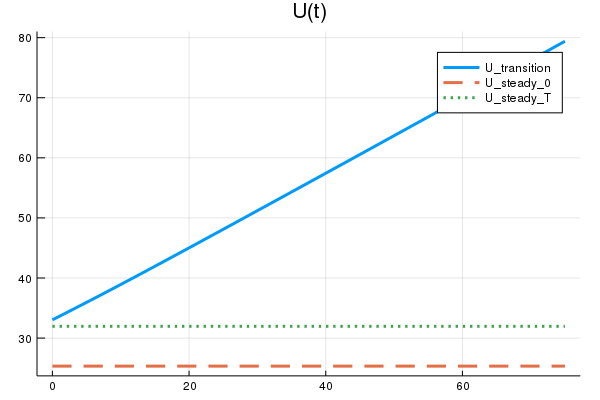

In [23]:
# generate the plot!
U_steady_0(t) = stationary_sol_0.U_bar
U_steady_T(t) = stationary_sol.U_bar

plot(solved.t, 
    [solved.U, U_steady_0, U_steady_T], 
    label = ["U_transition", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

### Outstanding Issue \#2: Welfare Gains still depend on T in transition path.

The stuff above I think is correct, the one issue is why does the welfare gains, inclusive of the transition path seem to depend on T??? So change T above from 40 to 75 or 100, then the welfare gains fall alot? Why?

---
## Plotting

In [24]:
solved.U[end]

79.40243025377117

## Plots for Ω and residuals

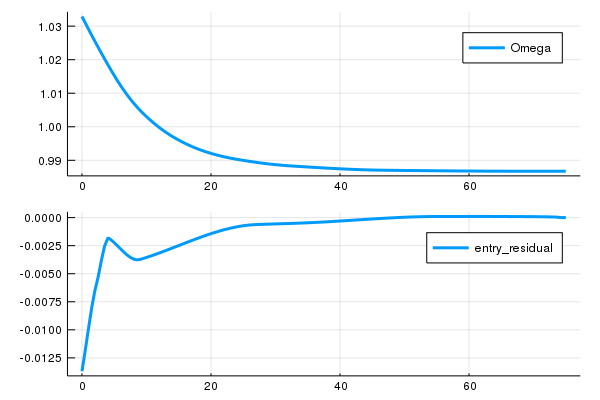

In [25]:
#solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

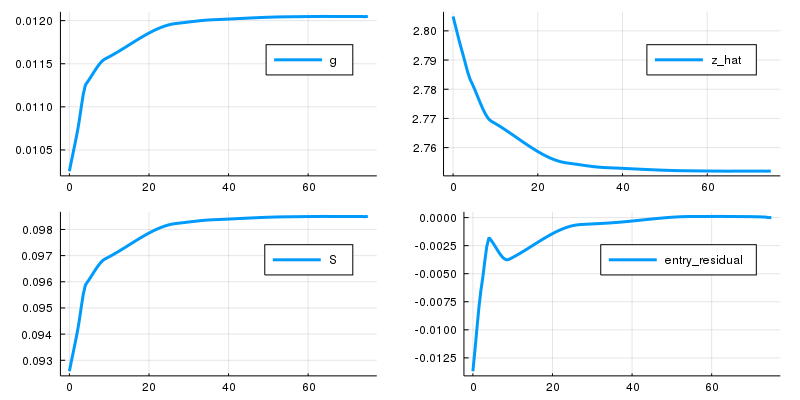

In [26]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

## Static Equations

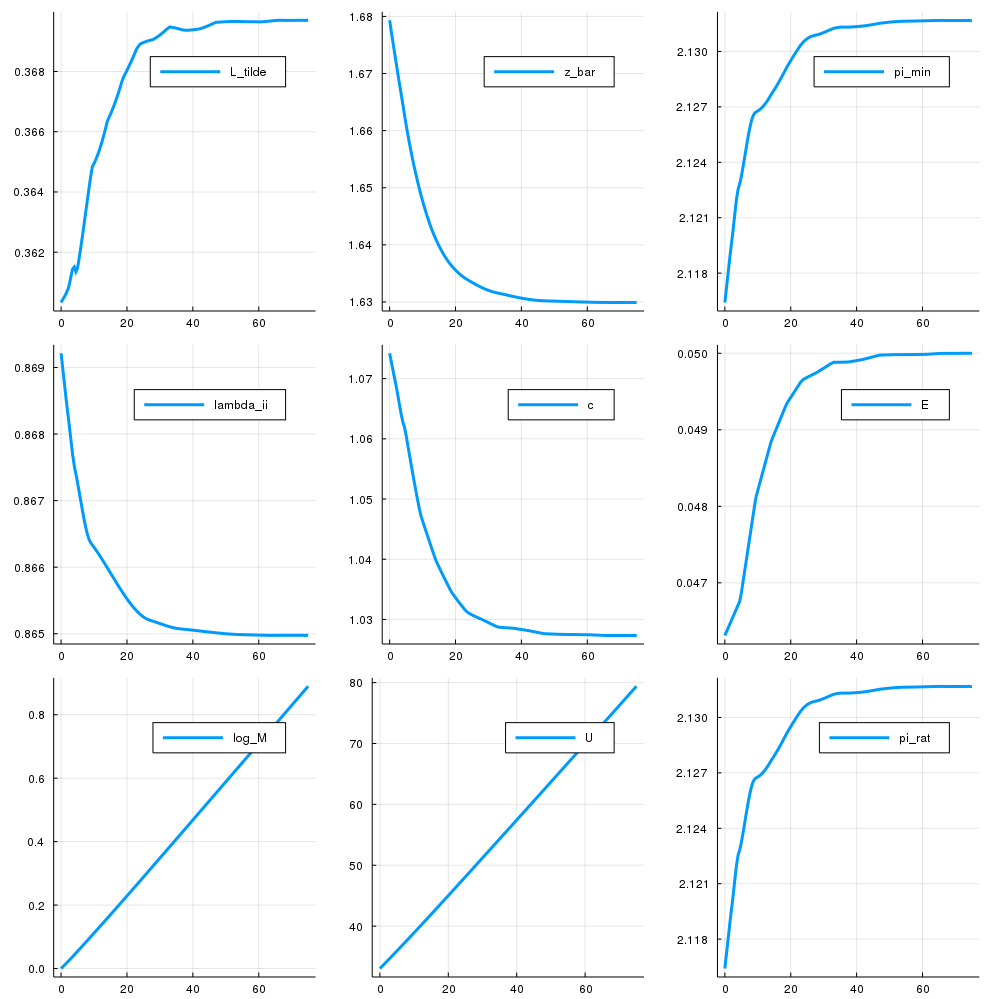

In [27]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_rat, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(solved.t, solved.π_rat, label = "pi_rat", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, layout=(3,3), size = (1000, 1000))

# Welfare analysis

### `log_M(t)`

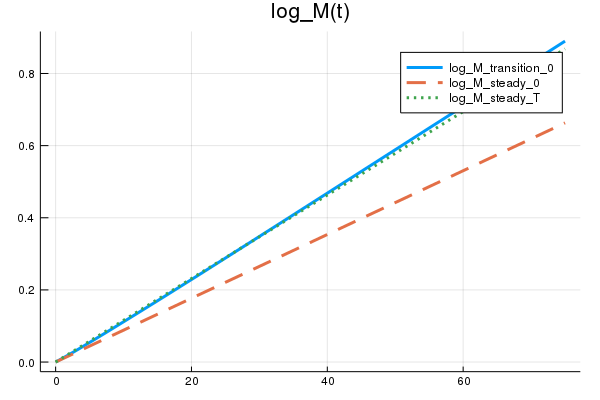

In [28]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

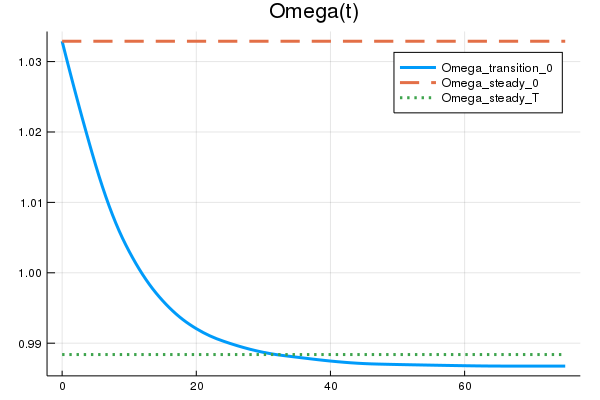

In [29]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

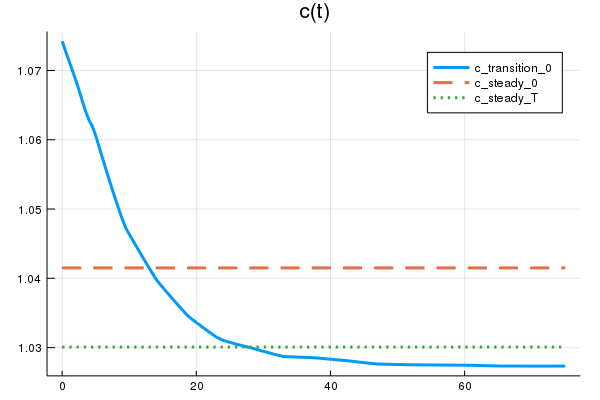

In [30]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

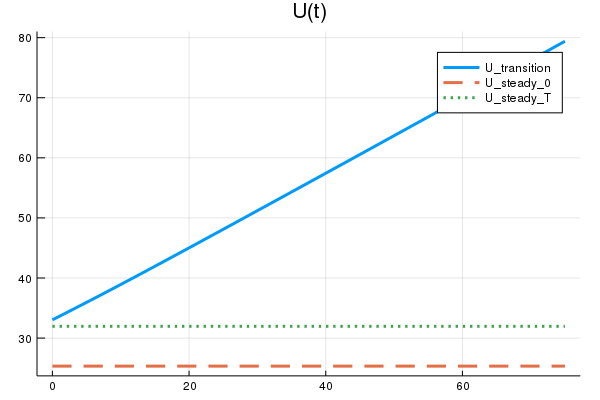

In [31]:
# generate the plot!
U_steady_0(t) = stationary_sol_0.U_bar
U_steady_T(t) = stationary_sol.U_bar

plot(solved.t, 
    [solved.U, U_steady_0, U_steady_T], 
    label = ["U_transition", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [32]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar, parameters)

2.8699967010781595

### `M(0)` by autarky and transition from `t=0`

In [33]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar, parameters)

1.1620662245894877

But if we include the transition path, this falls a lot. Like down to 13 percent gain. 

In [34]:
# solved 
# Run the above to see the whole dataframe

In [35]:
using DataFrames

df_stationary = DataFrame(t = -1.00, g =stationary_sol_0.g, λ_ii = stationary_sol_0.λ_ii, c = stationary_sol_0.c, L_tilde = stationary_sol_0.L_tilde, Ω = stationary_sol_0.Ω,
    π_rat = stationary_sol_0.π_rat, L_tilde_a = stationary_sol_0.L_tilde_a, L_tilde_x = stationary_sol_0.L_tilde_x, L_tilde_E= stationary_sol_0.L_tilde_E);

In [36]:
CSV.write("stationary_results.csv", df_stationary)

"stationary_results.csv"

In [37]:
df_transition = DataFrame(t = solved.t, g =solved.g, λ_ii = solved.λ_ii, c = solved.c, L_tilde = solved.L_tilde, Ω = solved.Ω,
    π_rat = solved.π_rat, L_tilde_a = solved.L_tilde_a, L_tilde_x = solved.L_tilde_x, L_tilde_E= solved.L_tilde_E);

In [38]:
CSV.write("transition_results.csv", df_transition)

"transition_results.csv"

In [39]:
stationary_sol_0.π_rat

1.7250561867295242

In [40]:
df_welfare = DataFrame(steady_state = lambda_ss, transition_path = lambda_tpath, growth_rate = stationary_sol.g, theta = parameters.θ);
CSV.write("welfare_results.csv", df_welfare)

"welfare_results.csv"

In [41]:
df_autarky = DataFrame(steady_state = lambda_ss_autarky, growth_rate = stationary_autarky.g, theta = parameters.θ);
CSV.write("autarky_welfare_results.csv", df_autarky)

"autarky_welfare_results.csv"

### R and W

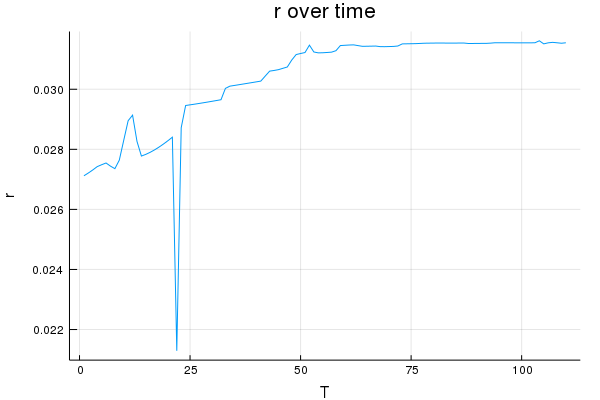

In [42]:
plot(solved.r, legend = false, title = "r over time", xlabel = "T", ylabel = "r")

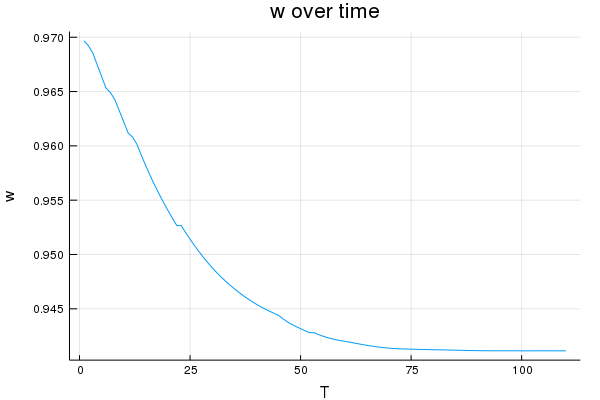

In [43]:
plot(solved.w, legend = false, title = "w over time", xlabel = "T", ylabel = "w")

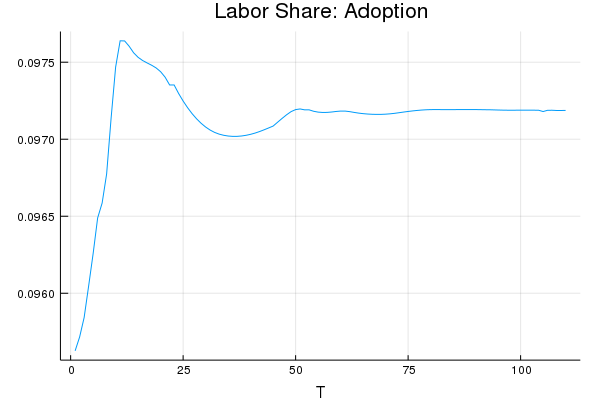

In [44]:
plot(solved.L_tilde_a, legend = false, xlabel = "T", title = "Labor Share: Adoption")

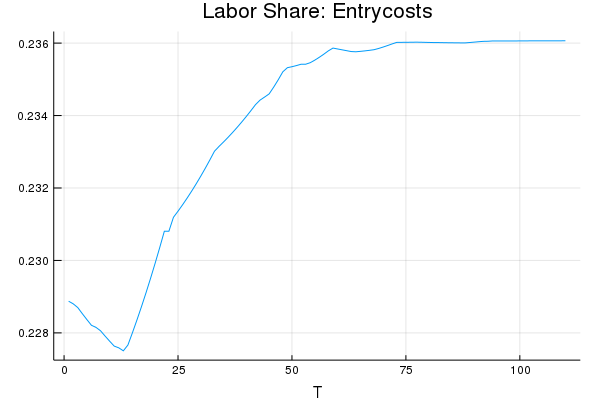

In [45]:
plot(solved.L_tilde_E, legend = false, xlabel = "T", title = "Labor Share: Entrycosts")

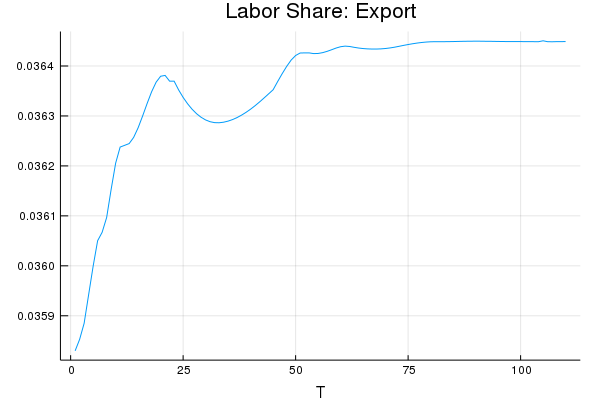

In [46]:
plot(solved.L_tilde_x, legend = false, xlabel = "T", title = "Labor Share: Export")